# Occlusion sensitivity

## Theoretical Explanation

References:
* https://towardsdatascience.com/inshort-occlusion-analysis-for-explaining-dnns-d0ad3af9aeb6
* https://www.youtube.com/watch?v=gCJCgQW_LKc 

The basic concept is as simple as they come: For every input dimension of an input x, we evaluate the model with that dimension missing, and observe how the output changes.
In particular, if ||f(x) — f(x_without_i)|| is large, then the dimension must have been important because removing it changes the output a lot.

<img src="https://miro.medium.com/max/720/1*ogpaKqqoD7radhozbmKnfw.png" width="500">

Unfortunately, in most cases, such as image data, this is not the case. Here, you would be advised to remove whole patches instead of individual pixels. The idea is that usually the information of a single pixel can be reconstructed from its neighbors. So **if you have an image of a cat, removing one cat-pixel will never have a large effect on the output, whereas removing the patch covering an ear might lead to a noticeable drop in the model’s prediction for ‘cat’**.

As long as you can feed in inputs and receive outputs, you can use occlusion analysis. 
In some cases this could be used to remove noise of an image and improve classification confidence.

## Tensorflow General configs and imports

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import pandas as pd 
import numpy as np
import seaborn as sns
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Imports

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow import keras
from IPython.display import Image, display
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import BoundaryNorm
from matplotlib.colorbar import ColorbarBase
import pathlib
import cv2
import copy
import math
import pylab

## Data pre-processing

In [3]:
# Obtain and prepare dataset

data_dir = pathlib.Path('../input/monkeypoxdataset/MonkeypoxSkinDataset')

# Input size Final
batch_size = 32
IMG_SIZE = (124,124)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  shuffle=True,
  image_size=IMG_SIZE,
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle=True,
  image_size=IMG_SIZE,
  batch_size=batch_size)

class_names = train_ds.class_names

Found 42350 files belonging to 6 classes.
Using 33880 files for training.
Found 42350 files belonging to 6 classes.
Using 8470 files for validation.


In [4]:
train_ds = train_ds.cache().prefetch(1)
val_ds = val_ds.cache().prefetch(1)

val_batches = val_ds.cardinality().numpy()
test_ds = val_ds.take(val_batches // 3) 
val_ds = val_ds.skip(val_batches // 3)

normalization_layer = keras.layers.experimental.preprocessing.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

## Transfer Learning on Xception model

In [5]:
# create the base pre-trained model
base_model = keras.applications.xception.Xception(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# and a logistic layer -- let's say we have 6 classes
predictions = Dense(6, activation='softmax')(x)

83697664/83683744 [==============================] - 0s 0us/step


In [6]:
# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

In [7]:
# this is the model we will train
xception_model = Model(inputs=base_model.input, outputs=predictions)

In [8]:
# Load model if already trained
# Ignore warning "Could not open.." - it will work even with that message

xception_model.load_weights('../input/xceptionmodeltf/xceptionmodeltfv2')

In [9]:
# Even if you load an already trained model in cell above you need to compile it as well

optimizer = tf.keras.optimizers.Adam(epsilon=0.01)

xception_model.compile(
    optimizer=optimizer,
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

In [10]:
# Training (will take time if no GPU or TPU is being used - even with GPU/TPU it takes a while)
# Dont run it if you already load the weights

history = xception_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs = 10,
)

Epoch 1/10
1059/1059 [==============================] - 109s 94ms/step - loss: 0.3508 - accuracy: 0.8814 - val_loss: 0.4083 - val_accuracy: 0.8536
Epoch 2/10
1059/1059 [==============================] - 37s 35ms/step - loss: 0.3374 - accuracy: 0.8853 - val_loss: 0.3961 - val_accuracy: 0.8566
Epoch 3/10
1059/1059 [==============================] - 37s 35ms/step - loss: 0.3222 - accuracy: 0.8903 - val_loss: 0.3858 - val_accuracy: 0.8590
Epoch 4/10
1059/1059 [==============================] - 37s 35ms/step - loss: 0.3091 - accuracy: 0.8945 - val_loss: 0.3776 - val_accuracy: 0.8624
Epoch 5/10
1059/1059 [==============================] - 36s 34ms/step - loss: 0.2981 - accuracy: 0.8983 - val_loss: 0.3711 - val_accuracy: 0.8636
Epoch 6/10
1059/1059 [==============================] - 37s 35ms/step - loss: 0.2886 - accuracy: 0.9016 - val_loss: 0.3658 - val_accuracy: 0.8677
Epoch 7/10
1059/1059 [==============================] - 37s 35ms/step - loss: 0.2804 - accuracy: 0.9043 - val_loss: 0.3615 

<AxesSubplot:>

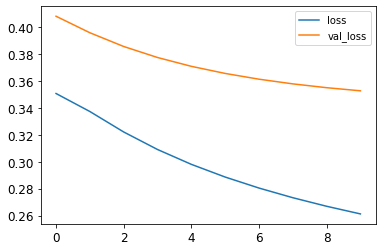

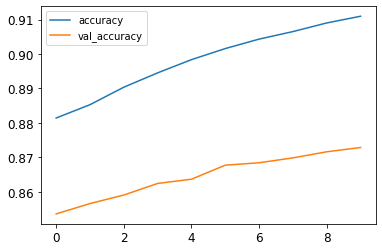

In [11]:
# Results visualization
# Loss and validation loss variation 

history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

In [12]:
#Save the previous trained model

modelSaving = xception_model.save_weights('./xceptionmodel', save_format='h5')

In [13]:
#test sample evaluation

score = xception_model.evaluate(test_ds)
print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

88/88 [==============================] - 3s 32ms/step - loss: 0.3263 - accuracy: 0.8835
Test loss:  0.3263017535209656
Test accuracy:  0.8835227489471436


## Occlusion Sensivity implementation

In [14]:
def iter_occlusion(image, size=8):
    # taken from https://www.kaggle.com/blargl/simple-occlusion-and-saliency-maps
    occlusion = np.full((size * 5, size * 5, 1), [0.5], np.float32)
    occlusion_center = np.full((size, size, 1), [0.5], np.float32)
    occlusion_padding = size * 2

    # print('padding...')
    image_padded = np.pad(image, ( \
    (occlusion_padding, occlusion_padding), (occlusion_padding, occlusion_padding), (0, 0) \
    ), 'constant', constant_values = 0.0)

    for y in range(occlusion_padding, image.shape[0] + occlusion_padding, size):

        for x in range(occlusion_padding, image.shape[1] + occlusion_padding, size):
            tmp = image_padded.copy()

            tmp[y - occlusion_padding:y + occlusion_center.shape[0] + occlusion_padding, \
                x - occlusion_padding:x + occlusion_center.shape[1] + occlusion_padding] \
                = occlusion

            tmp[y:y + occlusion_center.shape[0], x:x + occlusion_center.shape[1]] = occlusion_center

            yield x - occlusion_padding, y - occlusion_padding, \
                tmp[occlusion_padding:tmp.shape[0] - occlusion_padding, occlusion_padding:tmp.shape[1] - occlusion_padding]

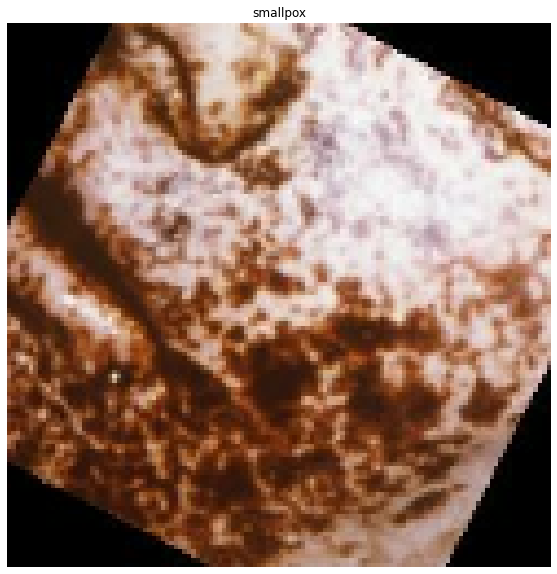

In [15]:
plt.figure(figsize=(15, 10))
for images, labels in train_ds.take(1):
    for i in range(1):
        imageSelected = images[i].numpy().astype("float32")
        correct_class = labels[i]
        plt.imshow(imageSelected) #pode ser transformado num array numpy 
        plt.title(class_names[correct_class])
        plt.axis("off")

In [16]:
# input tensor for model.predict
data = imageSelected
inp = imageSelected.reshape((1,124,124,3))

pred = xception_model.predict(inp).argmax(axis=1)[0]
class_names[pred]

'smallpox'

In [17]:
# This function will occlude some pixels and try to predict the right class
# With it we will wich picture area is the most important on prediction
# Big output - i need to clear it to short the notebook size

# image data for matplotlib's imshow
img = imageSelected

# occlusion
img_size = img.shape[0]
occlusion_size = 4

print('occluding...')

heatmap = np.zeros((img_size, img_size), np.float32)
class_pixels = np.zeros((img_size, img_size), np.int16)

from collections import defaultdict
counters = defaultdict(int)

for n, (x, y, img_float) in enumerate(iter_occlusion(data, size=occlusion_size)):

    X = img_float.reshape((1,124,124,3))
    out = xception_model.predict(X)
    print('#{}: {} @ {} (correct class: {})'.format(n, np.argmax(out), np.amax(out), out[0][correct_class]))
    print('x {} - {} | y {} - {}'.format(x, x + occlusion_size, y, y + occlusion_size))

    heatmap[y:y + occlusion_size, x:x + occlusion_size] = out[0][correct_class]
    class_pixels[y:y + occlusion_size, x:x + occlusion_size] = np.argmax(out)
    counters[np.argmax(out)] += 1
    

pred = xception_model.predict(inp)
print('Correct class: {}'.format(correct_class))
print('Predicted class: {} (prob: {})'.format(np.argmax(pred), np.amax(out)))
print('Predictions:')
for class_id, count in counters.items():
    print('{}: {}'.format(class_id, count))

occluding...
#0: 5 @ 0.9223080277442932 (correct class: 0.9223080277442932)
x 0 - 4 | y 0 - 4
#1: 5 @ 0.8849189877510071 (correct class: 0.8849189877510071)
x 4 - 8 | y 0 - 4
#2: 5 @ 0.8930684328079224 (correct class: 0.8930684328079224)
x 8 - 12 | y 0 - 4
#3: 5 @ 0.9337776303291321 (correct class: 0.9337776303291321)
x 12 - 16 | y 0 - 4
#4: 5 @ 0.9380593299865723 (correct class: 0.9380593299865723)
x 16 - 20 | y 0 - 4
#5: 5 @ 0.9290436506271362 (correct class: 0.9290436506271362)
x 20 - 24 | y 0 - 4
#6: 5 @ 0.9310957193374634 (correct class: 0.9310957193374634)
x 24 - 28 | y 0 - 4
#7: 5 @ 0.9245423078536987 (correct class: 0.9245423078536987)
x 28 - 32 | y 0 - 4
#8: 5 @ 0.8540015816688538 (correct class: 0.8540015816688538)
x 32 - 36 | y 0 - 4
#9: 5 @ 0.758392333984375 (correct class: 0.758392333984375)
x 36 - 40 | y 0 - 4
#10: 5 @ 0.6596329808235168 (correct class: 0.6596329808235168)
x 40 - 44 | y 0 - 4
#11: 5 @ 0.5554937124252319 (correct class: 0.5554937124252319)
x 44 - 48 | y 0 

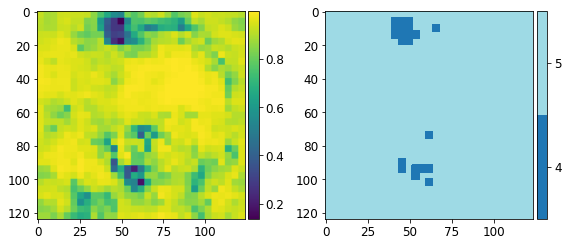

In [18]:
#Plot figures with the most important pixels to classify the image as the right class

fig = plt.figure(figsize=(8, 8))

ax1 = plt.subplot(1, 2, 1, aspect='equal')
hm = ax1.imshow(heatmap)

ax2 = plt.subplot(1, 2, 2, aspect='equal')


vals = np.unique(class_pixels).tolist()
bounds = vals + [vals[-1] + 1]  # add an extra item for cosmetic reasons

custom = cm.get_cmap('tab20', len(bounds)) # discrete colors

norm = BoundaryNorm(bounds, custom.N)

cp = ax2.imshow(class_pixels, norm=norm, cmap=custom)

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", size="5%", pad=0.05)
cbar1 = plt.colorbar(hm, cax=cax1)

divider = make_axes_locatable(ax2)
cax2 = divider.append_axes("right", size="5%", pad=0.05)
cbar2 = ColorbarBase(cax2, cmap=custom, norm=norm,
                         # place the ticks at the average value between two entries
                         # e.g. [280, 300] -> 290
                         # so that they're centered on the colorbar
                         ticks=[(a + b) / 2.0 for a, b in zip(bounds[::], bounds[1::])],
                         boundaries=bounds, spacing='uniform', orientation='vertical')

cbar2.ax.set_yticklabels([n for n in np.unique(class_pixels)])

fig.tight_layout()

plt.show()

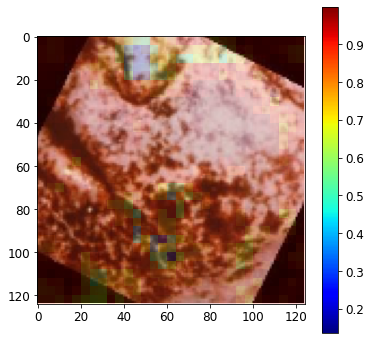

In [19]:
#The scale shows the confidence on predicting the right class when the pixel is hidden.

plt.figure(figsize=(6, 6))

plt.imshow(img, cmap=cm.gray)

plt.pcolormesh(heatmap, cmap=plt.cm.jet, alpha=0.20)
plt.colorbar().solids.set(alpha=1)

plt.show()